In [1]:

!pip install datasets

!pip install nltk
!pip install textblob

!pip install mljar-supervised


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.6 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-1.1.17-py3-none-any.whl size=164663 sha256=18ede31548e274a95bb

In [2]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 

# Restart the Session

In [1]:
import numpy
from datasets import load_dataset
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

from supervised.automl import AutoML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!rm -rf ~/.cache/huggingface/datasets

In [3]:

hgds = load_dataset("Hello-SimpleAI/HC3", "all")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

HC3.py:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/39.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

In [4]:
data = hgds['train']

human_rows = []
for row in data:
    for ans in row['human_answers']:
        human_rows.append({'text': ans, 'label': 0})

ai_rows = []
for row in data:
    for ans in row['chatgpt_answers']:
        ai_rows.append({'text': ans, 'label': 1})

df_human = pd.DataFrame(human_rows)
df_ai = pd.DataFrame(ai_rows)

df = pd.concat([df_human, df_ai]).sample(frac=1).reset_index(drop=True)

df.head()

,text,label
0,"No , it would not . Unless you built the eleva...",0
1,Default logic is a form of non-monotonic logic...,1
2,We 've run out of keys long ago . But there ar...,0
3,Making a movie is expensive for many reasons. ...,1
4,It is not clear what you are asking about with...,1


In [5]:

nltk.download('stopwords')
nltk.download('wordnet')

def text_to_words(document):
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()

    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())

    return normalized

df["clean_text"] = df["text"].apply(text_to_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:

df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))

df['text_length'] = df['clean_text'].apply(len)

df['avg_word_length'] = df['clean_text'].apply(lambda x: sum(len(w) for w in x.split()) / (len(x.split())+1e-5))

df['num_exclamations'] = df['text'].apply(lambda x: x.count('!'))

df['num_questions'] = df['text'].apply(lambda x: x.count('?'))


In [7]:

df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [8]:
df

,text,label,clean_text,word_count,text_length,avg_word_length,num_exclamations,num_questions,polarity,subjectivity
0,"No , it would not . Unless you built the eleva...",0,would unless built elevator massive enough sig...,15,110,6.399996,0,0,0.118750,0.693750
1,Default logic is a form of non-monotonic logic...,1,default logic form nonmonotonic logic used rea...,95,763,7.042105,0,0,0.061023,0.509659
2,We 've run out of keys long ago . But there ar...,0,ve run key long ago enough different key patte...,17,89,4.294115,0,0,-0.021429,0.628571
3,Making a movie is expensive for many reasons. ...,1,making movie expensive many reason one reason ...,47,304,5.489361,0,0,0.142857,0.578571
4,It is not clear what you are asking about with...,1,clear asking term nm could provide context cla...,9,59,5.666660,0,1,0.100000,0.383333
...,...,...,...,...,...,...,...,...,...,...
85444,Mandarin and Cantonese are both dialects of th...,1,mandarin cantonese dialect chinese language sp...,111,890,7.027026,0,0,0.031481,0.340741
85445,Cats purr by vibrating the muscles in their la...,1,cat purr vibrating muscle larynx voice box inh...,112,820,6.330357,0,0,0.137612,0.461793
85446,It is a preventative measure to ensure that dr...,0,preventative measure ensure dry grass flammabl...,39,274,6.051280,0,0,-0.070370,0.588889
85447,Well if we are talking non professionals ( so ...,0,well talking non professional college though m...,333,2178,5.543543,1,3,0.131599,0.481327


In [9]:

print(df['label'].value_counts())


label
0    58546
1    26903
Name: count, dtype: int64


AutoML directory: AutoML_10
The task is binary_classification with evaluation metric f1
AutoML will use algorithms: ['LightGBM', 'Xgboost', 'Random Forest', 'Extra Trees']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models
1_Default_LightGBM f1 0.864237 trained in 63.32 seconds
2_Default_Xgboost f1 0.843806 trained in 56.68 seconds
3_Default_RandomForest f1 0.816869 trained in 36.38 seconds
4_Default_ExtraTrees f1 0.811009 trained in 10.8 seconds
* Step ensemble will try to check up to 1 model
Ensemble f1 0.864237 trained in 5.0 seconds
AutoML fit time: 184.11 seconds
AutoML best model: 1_Default_LightGBM

Accuracy: 0.8303686366296079

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     11709
           1       0.73      0.74      0.73   

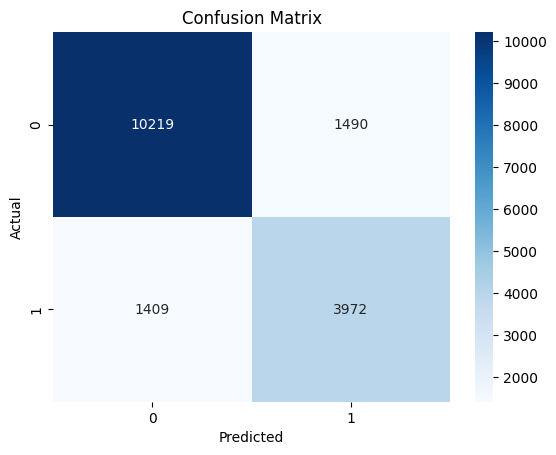


Leaderboard:
       model_type  metric_value  train_time
0       LightGBM     -0.864237       65.08
1        Xgboost     -0.843806       58.41
2  Random Forest     -0.816869       38.09
3    Extra Trees     -0.811009       12.46
4       Ensemble     -0.864237        5.00


In [16]:

X = df.drop(columns=["text", "label", "clean_text"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


automl = AutoML(
    mode="Explain",
    total_time_limit=300,
    eval_metric="f1",
    algorithms=["LightGBM", "Xgboost", "Random Forest", "Extra Trees"],
    explain_level=1,
    random_state=42
)

automl.fit(X_resampled, y_resampled)

preds = automl.predict(X_test_scaled)
print("\nAccuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))

sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

leaderboard = automl.get_leaderboard()
print("\nLeaderboard:\n", leaderboard[["model_type", "metric_value", "train_time"]])

automl.report()